### Importy

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import optuna
import tensorflow as tf
import numpy as np
from scripts.train_utilities import *
from scripts.essentials import *
from tensorflow.keras.callbacks import EarlyStopping
from scripts.plots import *
import random
from pickle import load
from plots import *
from sklearn.metrics import roc_auc_score
from scipy.special import expit

In [2]:
prefix = "BA"

In [3]:
if prefix == 'BTC-USD':
  df = pd.read_csv(f'{prefix}_with_weekends.csv')
  step = 7
else:
  df = pd.read_csv(f'{prefix}_without_weekends.csv')
  step = 5

cols_min_max = ['^GSPC_Volume', prefix+'_Volume',
'daily_variation', 'high_close_pressure', 'low_open_pressure',
'low_norm', 'close_norm', 'high_norm', 'open_norm']

scaler_min_max = load(open(f'scaler/scaler_min_max_{prefix}.pkl', 'rb'))
df = min_max_scale(df,'Date', cols_min_max, train_data=False, scaler=scaler_min_max)

if prefix == 'BTC-USD':
  df['target_7'] = df['log_return_7'].shift(-7)

else:
  df['target_1'] = df['log_return_1'].shift(-1)
  df['target_5'] = df['log_return_5'].shift(-5)

df = df[df['Date']>= '2021-01-01'].reset_index(drop=True)

### Optuna

In [4]:
random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

In [12]:
def objective(trial):
    model = create_model(trial, input_shape=(X.shape[1], X.shape[2]))

    early_stopping = EarlyStopping(monitor='val_custom_auc', patience=35, mode='max', restore_best_weights=True)

    model.fit(X, y, epochs=200, validation_data=(X_val, y_val),
                        callbacks=[early_stopping], verbose=0)

    # Evaluate the model
    number = random.randint(1,10000)
    print(number)
    model.save(f'{number}_lstm.h5')
    val_loss, val_score = model.evaluate(X_val, y_val, verbose=0)
    return val_score

In [ ]:
# Dane finansowe
window_size = 10
target_cols = ['target_5']
cols_used = [
'norm_rsi_14', 'norm_slowk_14', 'minmax_daily_variation', 'minmax_BA_Volume'
]

X_full, y_full = window_dataset(df[list(cols_used)+target_cols],  target_cols[0], window_size)
X, y, X_val, y_val, X_test, y_test = X_full[:656-window_size], y_full[:656-window_size],\
                                  X_full[(656-window_size):(656-window_size+40)], y_full[(656-window_size):(656-window_size+40)], \
                                  X_full[(656-window_size+40):-5], y_full[(656-window_size+40):-5]
study_f = optuna.create_study(direction='maximize')
study_f.optimize(objective, n_trials=15)  

print(study_f.best_params)

In [ ]:
# Dane newsowe
window_size = 10
target_cols = ['target_5']
cols_used = [
'mean_influential', 'mean_trustworthy', 'finbert_Score', 'bart_Score'
              ]

X_full, y_full = window_dataset(df[list(cols_used)+target_cols],  target_cols[0], window_size)
X, y, X_val, y_val, X_test, y_test = X_full[:656-window_size], y_full[:656-window_size],\
                                  X_full[(656-window_size):(656-window_size+40)], y_full[(656-window_size):(656-window_size+40)], \
                                  X_full[(656-window_size+40):-5], y_full[(656-window_size+40):-5]
study_n = optuna.create_study(direction='maximize')
study_n.optimize(objective, n_trials=15) 

print(study_n.best_params)

In [ ]:
# Pełne dane
window_size = 10
target_cols = ['target_5']
cols_used = [
'norm_rsi_14', 'norm_slowk_14', 'minmax_daily_variation', 'minmax_BA_Volume',
'mean_influential', 'mean_trustworthy', 'finbert_Score', 'bart_Score'
             ]

X_full, y_full = window_dataset(df[list(cols_used)+target_cols],  target_cols[0], window_size)
X, y, X_val, y_val, X_test, y_test = X_full[:656-window_size], y_full[:656-window_size],\
                                  X_full[(656-window_size):(656-window_size+40)], y_full[(656-window_size):(656-window_size+40)], \
                                  X_full[(656-window_size+40):-5], y_full[(656-window_size+40):-5]
study_full = optuna.create_study(direction='maximize')
study_full.optimize(objective, n_trials=15) 

print(study_full.best_params)

### Model Finance

In [86]:
window_size = 10
target_cols = ['target_5']
cols_used = [
'norm_rsi_14', 'norm_slowk_14', 'minmax_daily_variation', 'minmax_BA_Volume'
             ]

X,y,X_val,y_val,X_test,y_test,y_base0_train,y_base0_val,y_base0_test = get_x_y(df,cols_used)

In [ ]:
model = train_model_from_params(study_f.best_params, X, y, X_val, y_val)

In [88]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X)
y_pred_test = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [89]:
for y_true, y_pred in zip([y,y_val,y_test],[y_pred_train,y_pred_val,y_pred_test]):
  print(roc_auc_score(y_true>0,expit(y_pred)))

0.6025459688826026
0.584045584045584
0.6505376344086022


In [90]:
print(f'train')
print(count_signs_matrix(y, y_pred_train.flatten()))
print(f'val')
print(count_signs_matrix(y_val, y_pred_val.flatten()))
print(f'test')
print(count_signs_matrix(y_test, y_pred_test.flatten()))

train
[[231 112]
 [164 139]]
val
[[ 4  9]
 [ 9 18]]
test
[[ 7 17]
 [ 5 26]]


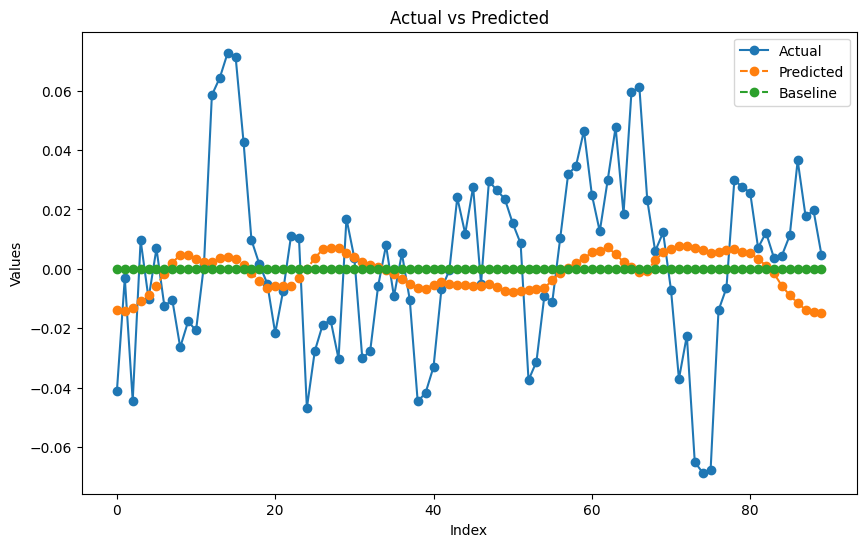

In [91]:
k=-90
m = 1
plot_actual_vs_predicted(y[k:], y_pred_train[k:]*m, [0 for i in range(y.shape[0])][k:])

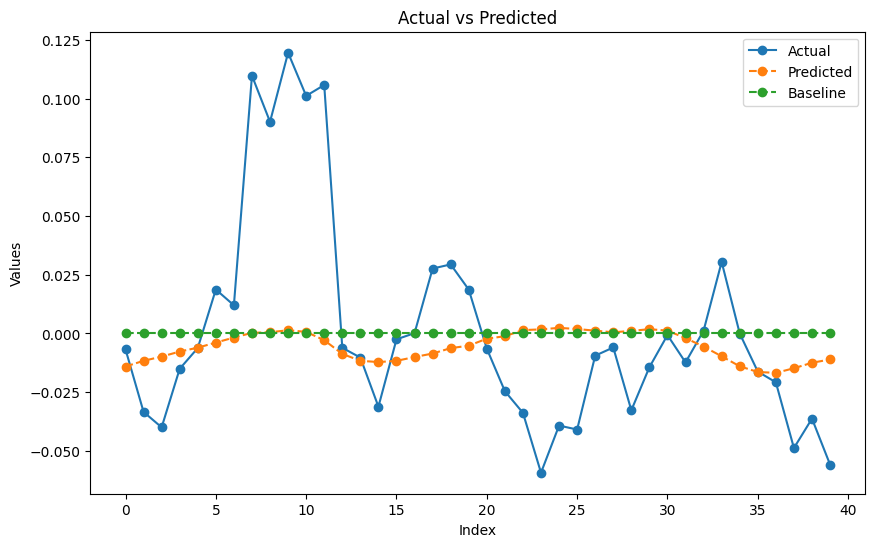

In [92]:
plot_actual_vs_predicted(y_val, y_pred_val*m, y_base0_val)

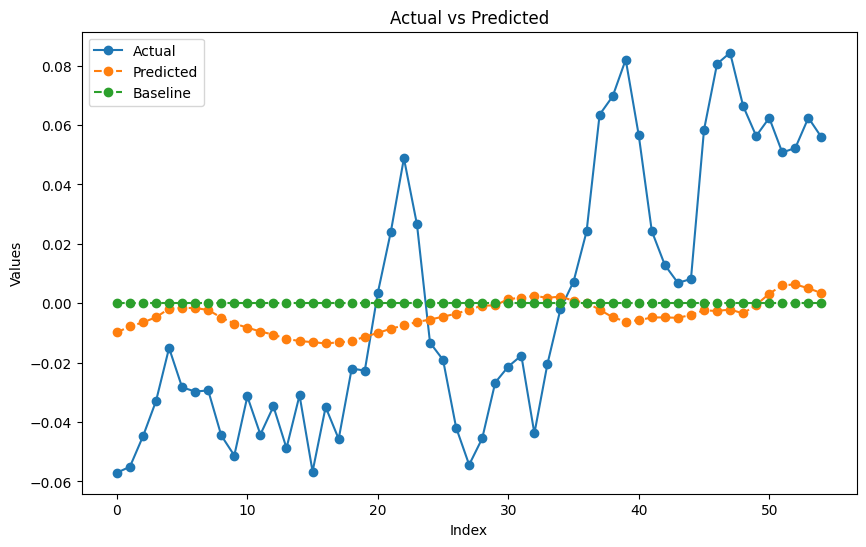

In [93]:
plot_actual_vs_predicted(y_test, y_pred_test*m, y_base0_test)

In [95]:
model.save(prefix+'_lstm_fin_cols.h5')

### Model News

In [106]:
window_size = 10
target_cols = ['target_5']
cols_used = [
'mean_influential', 'mean_trustworthy', 'finbert_Score', 'bart_Score'
]

X,y,X_val,y_val,X_test,y_test,y_base0_train,y_base0_val,y_base0_test = get_x_y(df,cols_used)

In [ ]:
model = train_model_from_params(study_n.best_params, X, y, X_val, y_val)

In [123]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X)
y_pred_test = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [124]:
for y_true, y_pred in zip([y,y_val,y_test],[y_pred_train,y_pred_val,y_pred_test]):
  print(roc_auc_score(y_true>0,expit(y_pred)))

0.4940440108150757
0.4672364672364672
0.5913978494623656


In [125]:
print(f'train')
print(count_signs_matrix(y, y_pred_train.flatten()))
print(f'val')
print(count_signs_matrix(y_val, y_pred_val.flatten()))
print(f'test')
print(count_signs_matrix(y_test, y_pred_test.flatten()))

train
[[150 193]
 [153 150]]
val
[[ 6  7]
 [14 13]]
test
[[10 14]
 [ 9 22]]


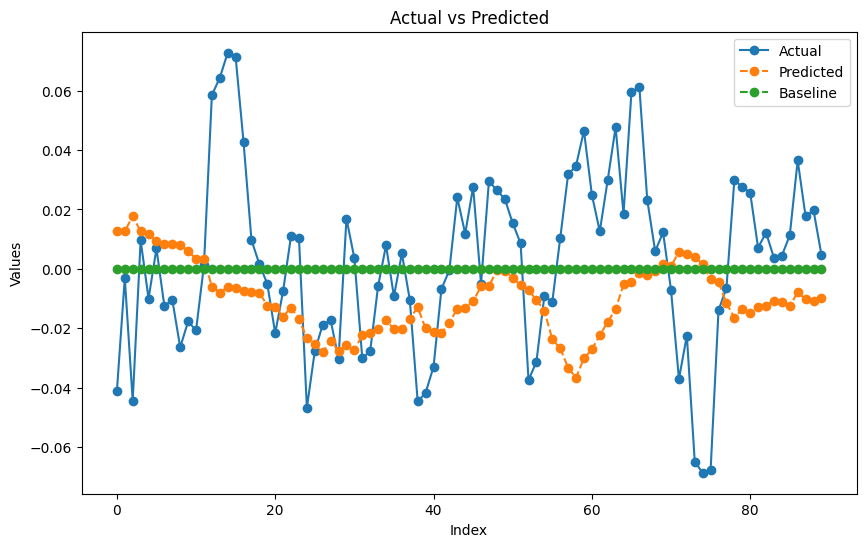

In [126]:
k=-90
m = 1
plot_actual_vs_predicted(y[k:], y_pred_train[k:]*m, y_base0_train[k:])

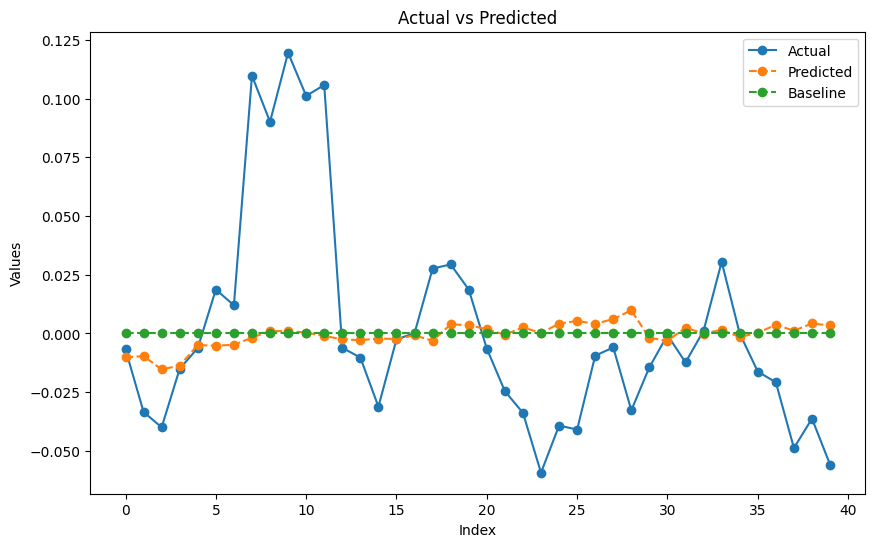

In [127]:
plot_actual_vs_predicted(y_val, y_pred_val*m, y_base0_val)

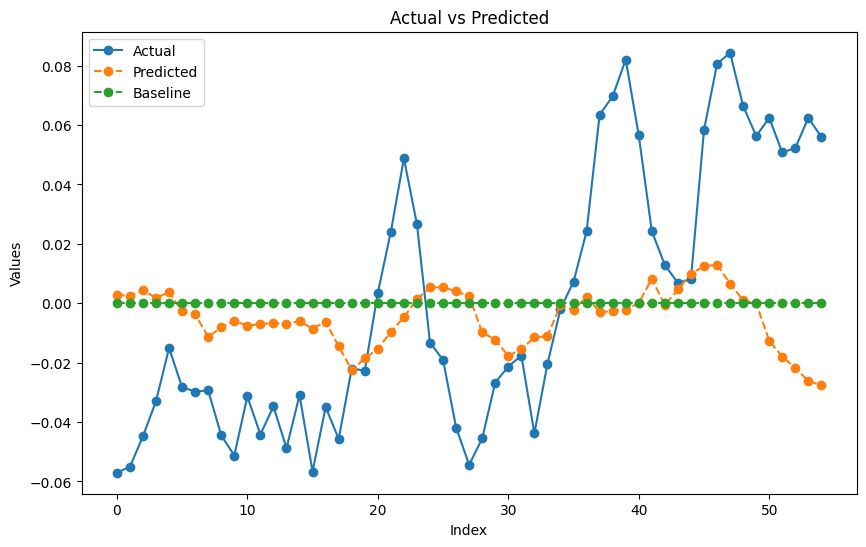

In [128]:
plot_actual_vs_predicted(y_test, y_pred_test*m, y_base0_test)

In [130]:
model.save(prefix+'_lstm_news_cols.h5')

### Model Full

In [46]:
window_size = 10
target_cols = ['target_5']
cols_used = [
'norm_rsi_14', 'norm_slowk_14', 'minmax_daily_variation', 'minmax_BA_Volume',
'mean_influential', 'mean_trustworthy', 'finbert_Score', 'bart_Score'
             ]

X,y,X_val,y_val,X_test,y_test,y_base0_train,y_base0_val,y_base0_test = get_x_y(df,cols_used)

In [ ]:
model = train_model_from_params(study_full.best_params, X, y, X_val, y_val)

In [69]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X)
y_pred_test = model.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [70]:
for y_true, y_pred in zip([y,y_val,y_test],[y_pred_train,y_pred_val,y_pred_test]):
  print(roc_auc_score(y_true>0,expit(y_pred)))

0.9168374563403862
0.6353276353276354
0.6330645161290323


In [71]:
print(f'train')
print(count_signs_matrix(y, y_pred_train.flatten()))
print(f'val')
print(count_signs_matrix(y_val, y_pred_val.flatten()))
print(f'test')
print(count_signs_matrix(y_test, y_pred_test.flatten()))

train
[[310  33]
 [ 78 225]]
val
[[11  2]
 [11 16]]
test
[[17  7]
 [16 15]]


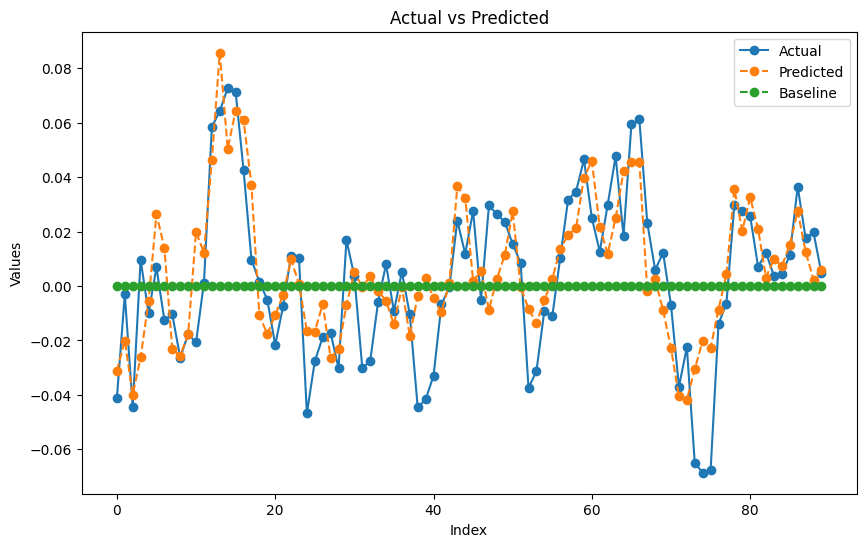

In [72]:
k=-90
m = 1
plot_actual_vs_predicted(y[k:], y_pred_train[k:]*m, y_base0_train[k:])

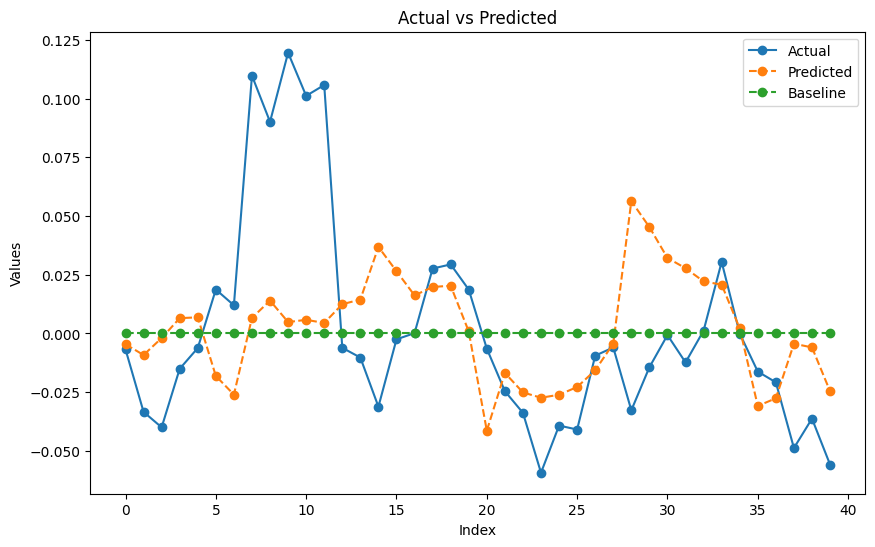

In [73]:
plot_actual_vs_predicted(y_val, y_pred_val*m, y_base0_val)

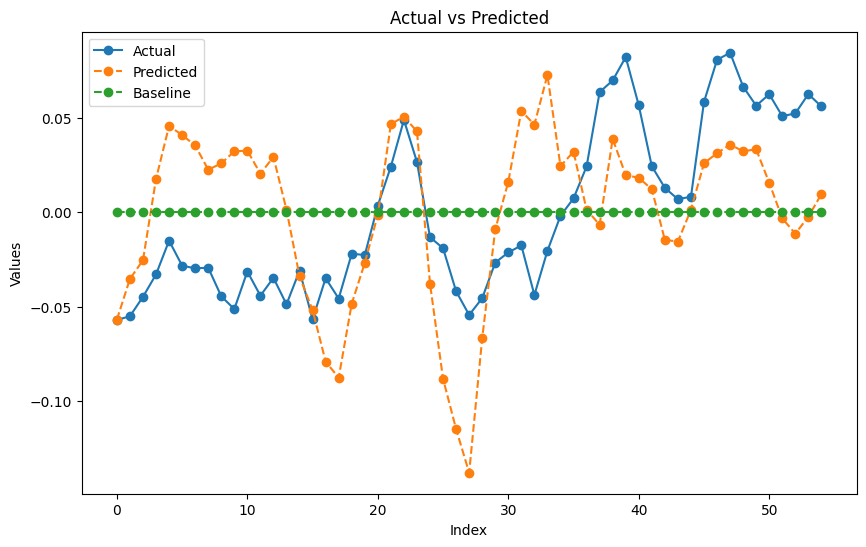

In [74]:
plot_actual_vs_predicted(y_test, y_pred_test*m, y_base0_test)

In [ ]:
model.save(prefix+'_lstm_full_cols.h5')